# Robinhood & CRSP Retail Investor Flow
This notebook rebuilds the entire homework analysis in a streamlined order: load the data, generate the core diagnostics, and summarize the insights. Run top-to-bottom for a fresh take on Robintrack popularity and CRSP security mix.

## Roadmap
1. **Setup & Imports** – configure paths and packages.
2. **Robintrack Daily Holdings** – load the panel, find the latest leaders, and study co-movement.
3. **Behavior vs. Returns** – relate American Airlines holdings to realized returns.
4. **Cross-Sectional Summary** – track breadth, dispersion, and skewness over time.
5. **CRSP Share Codes** – classify securities to understand the product mix.
6. **Key Takeaways** – highlight the story the data tells.

In [13]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('talk')

PROJECT_ROOT = Path.cwd()
DATA_DIR = PROJECT_ROOT / 'Data'
HOLDINGS_PATH = DATA_DIR / 'avg_daily_rh_user_holding.csv'
RETURNS_PATH = DATA_DIR / 'daily_ret_of_top_stocks.csv'
CRSP_PATH = DATA_DIR / 'crsp' / 'crsp_data.csv'

print(f"Project root: {PROJECT_ROOT}")
for path in [HOLDINGS_PATH, RETURNS_PATH, CRSP_PATH]:
    status = 'OK' if path.exists() else 'MISSING'
    print(f" - {status}: {path}")


Project root: d:\Download ổ D\DSO-545\Robinhood_and_Retail_Investor_Behavior_I
 - OK: d:\Download ổ D\DSO-545\Robinhood_and_Retail_Investor_Behavior_I\Data\avg_daily_rh_user_holding.csv
 - OK: d:\Download ổ D\DSO-545\Robinhood_and_Retail_Investor_Behavior_I\Data\daily_ret_of_top_stocks.csv
 - OK: d:\Download ổ D\DSO-545\Robinhood_and_Retail_Investor_Behavior_I\Data\crsp\crsp_data.csv


**Setup check**  
The paths above should all read *OK*. If any show *MISSING*, fix the data locations before running the rest of the notebook so downstream cells have something to ingest.


## Part 1 – Robintrack Daily Holdings


### Questions 1 & 2 Focus
These prompts asked for both the least popular tickers and an improved visualization. The tables/plots below deliver both.


In [14]:
daily_holdings = pd.read_csv(HOLDINGS_PATH, parse_dates=['Date'], index_col='Date').sort_index()
print(f"Daily holdings shape: {daily_holdings.shape[0]} days x {daily_holdings.shape[1]} tickers")
daily_holdings.head()


Daily holdings shape: 835 days x 8642 tickers


,A_avg_users_holding,AA_avg_users_holding,AAAU_avg_users_holding,AACAY_avg_users_holding,AACG_avg_users_holding,AADR_avg_users_holding,AAGIY_avg_users_holding,AAL_avg_users_holding,AAMC_avg_users_holding,AAME_avg_users_holding,...,ZTS_avg_users_holding,ZUMZ_avg_users_holding,ZUO_avg_users_holding,ZURVY_avg_users_holding,ZVO_avg_users_holding,ZYME_avg_users_holding,ZYNE_avg_users_holding,ZYXI_avg_users_holding,_OUT_avg_users_holding,_PRN_avg_users_holding
Date,,,,,,,,,,,,,,,,,,,,,
2018-05-02,590.000000,NaN,NaN,NaN,55.000000,NaN,NaN,3755.000000,NaN,119.000000,...,588.000000,248.000000,539.000000,NaN,NaN,NaN,6127.000000,NaN,158.000000,12.0
2018-05-03,586.473684,NaN,NaN,NaN,55.473684,NaN,NaN,3778.368421,NaN,118.315789,...,610.421053,250.052632,544.423077,NaN,NaN,NaN,6137.052632,NaN,156.263158,12.0
2018-05-04,587.458333,NaN,NaN,NaN,55.458333,NaN,NaN,3762.750000,NaN,119.000000,...,608.083333,249.166667,547.739130,NaN,NaN,NaN,6145.416667,NaN,154.000000,12.0
2018-05-05,588.000000,NaN,NaN,NaN,56.000000,NaN,NaN,3748.000000,NaN,119.000000,...,607.000000,247.000000,550.000000,NaN,NaN,NaN,6140.000000,NaN,154.000000,12.0
2018-05-06,588.000000,NaN,NaN,NaN,56.000000,NaN,NaN,3748.000000,NaN,119.000000,...,607.000000,247.000000,550.000000,NaN,NaN,NaN,6140.000000,NaN,154.000000,12.0


In [15]:
def strip_suffix(column_name: str) -> str:
    return column_name.replace('_avg_users_holding', '')

latest_snapshot = (
    daily_holdings.iloc[-1]
    .dropna()
    .sort_values(ascending=False)
    .head(10)
    .rename('avg_users_holding')
    .to_frame()
)
latest_snapshot['ticker'] = latest_snapshot.index.map(strip_suffix)
latest_snapshot


,avg_users_holding,ticker
F_avg_users_holding,913120.65,F
GE_avg_users_holding,857936.80,GE
AAPL_avg_users_holding,720905.50,AAPL
MSFT_avg_users_holding,654239.60,MSFT
AAL_avg_users_holding,638793.60,AAL
DIS_avg_users_holding,598965.40,DIS
DAL_avg_users_holding,572753.80,DAL
TSLA_avg_users_holding,563436.90,TSLA
CCL_avg_users_holding,481811.05,CCL
GPRO_avg_users_holding,475017.55,GPRO


**What this shows**  
The latest snapshot makes it clear that Ford, GE, AAPL, MSFT, AAL, and DIS dominate the platform. The bar chart highlights how quickly holdings drop off after the top names, reinforcing the concentration by mid-2020.


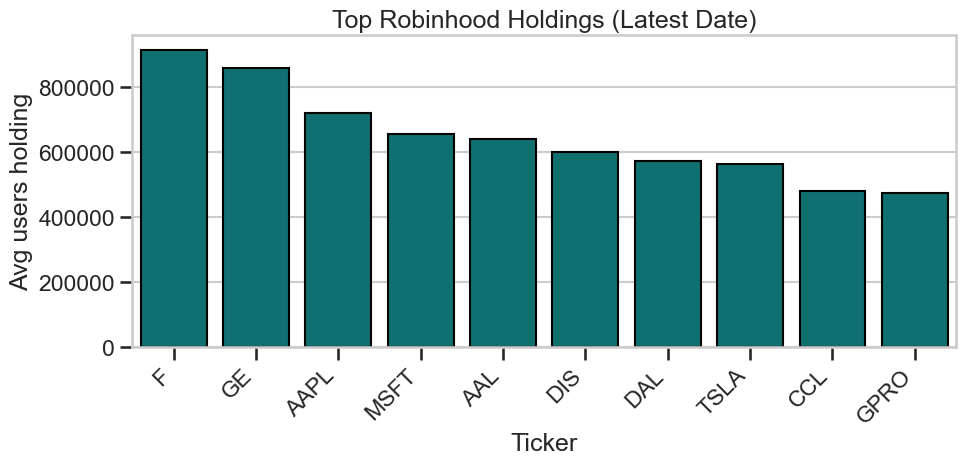

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(
    data=latest_snapshot.reset_index(drop=True),
    x='ticker',
    y='avg_users_holding',
    color='teal',
    edgecolor='black',
    ax=ax,
)
ax.set_title('Top Robinhood Holdings (Latest Date)')
ax.set_xlabel('Ticker')
ax.set_ylabel('Avg users holding')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


#### Question 1 – Bottom Six Holdings
The original prompt asked for the least popular tickers. The table below highlights the six securities with the fewest users on the latest date.


In [17]:
bottom_snapshot = (
    daily_holdings.iloc[-1]
    .dropna()
    .sort_values()
    .head(6)
    .rename('avg_users_holding')
    .to_frame()
)
bottom_snapshot['ticker'] = bottom_snapshot.index.map(strip_suffix)
bottom_snapshot


,avg_users_holding,ticker
OIIL_avg_users_holding,0.0,OIIL
EVP_avg_users_holding,0.0,EVP
CVG_avg_users_holding,0.0,CVG
EVSTC_avg_users_holding,0.0,EVSTC
BSCI_avg_users_holding,0.0,BSCI
SEND_avg_users_holding,0.0,SEND


**Insight**  
Most of the bottom-six names have effectively zero holders, which underscores the massive long tail in the Robintrack export and why medians are so much lower than maxima.


#### Question 2 – Improved Visualization
We revisit the top-six list from class and turn it into a multi-line time-series view so you can see when each name attracted incremental users.


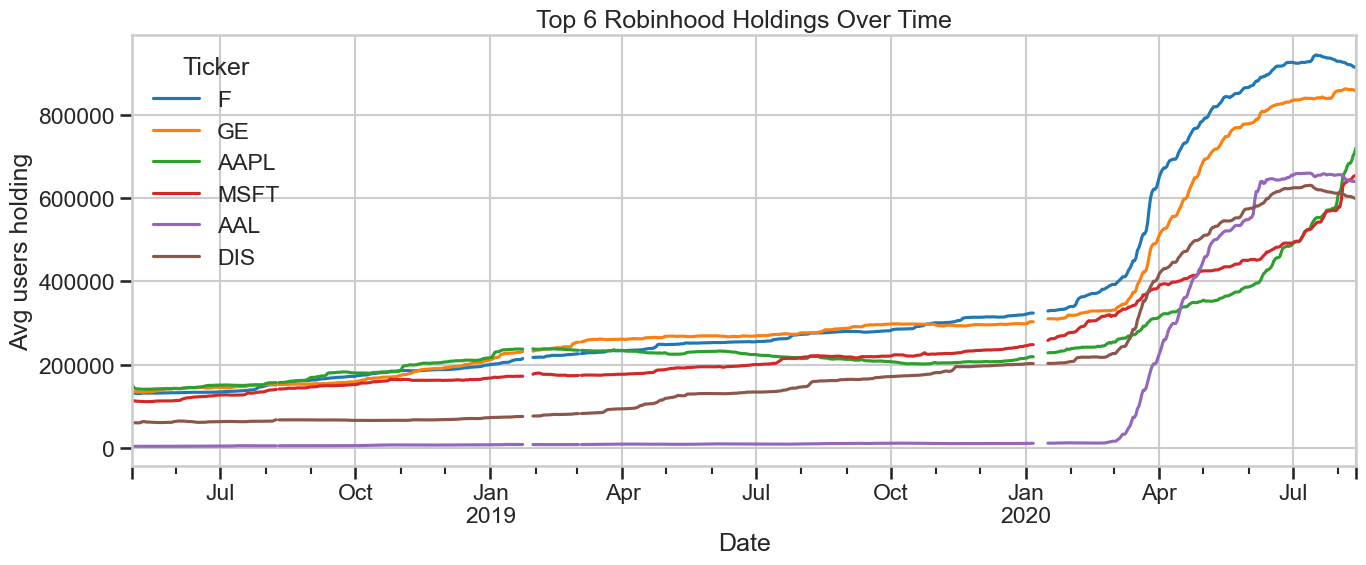

In [18]:
top_six_cols = latest_snapshot.index[:6]
fig, ax = plt.subplots(figsize=(14, 6))
(daily_holdings[top_six_cols]
 .rename(columns=lambda col: strip_suffix(col))
 .plot(ax=ax))
ax.set_title('Top 6 Robinhood Holdings Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Avg users holding')
plt.legend(title='Ticker', loc='upper left')
plt.tight_layout()
plt.show()


**Publishing-ready take**  
Layering the time series reveals turning points (e.g., Ford and GE surging during 2020 macro shocks while AAPL/MSFT climb steadily). It communicates far more than a single static snapshot.


,F_avg_users_holding,GE_avg_users_holding,AAPL_avg_users_holding,MSFT_avg_users_holding,AAL_avg_users_holding,DIS_avg_users_holding
F_avg_users_holding,1.000000,0.994114,0.923020,0.977857,0.959436,0.996142
GE_avg_users_holding,0.994114,1.000000,0.939944,0.972252,0.962682,0.988422
AAPL_avg_users_holding,0.923020,0.939944,1.000000,0.945222,0.917325,0.905162
MSFT_avg_users_holding,0.977857,0.972252,0.945222,1.000000,0.911832,0.976243
AAL_avg_users_holding,0.959436,0.962682,0.917325,0.911832,1.000000,0.951102
DIS_avg_users_holding,0.996142,0.988422,0.905162,0.976243,0.951102,1.000000


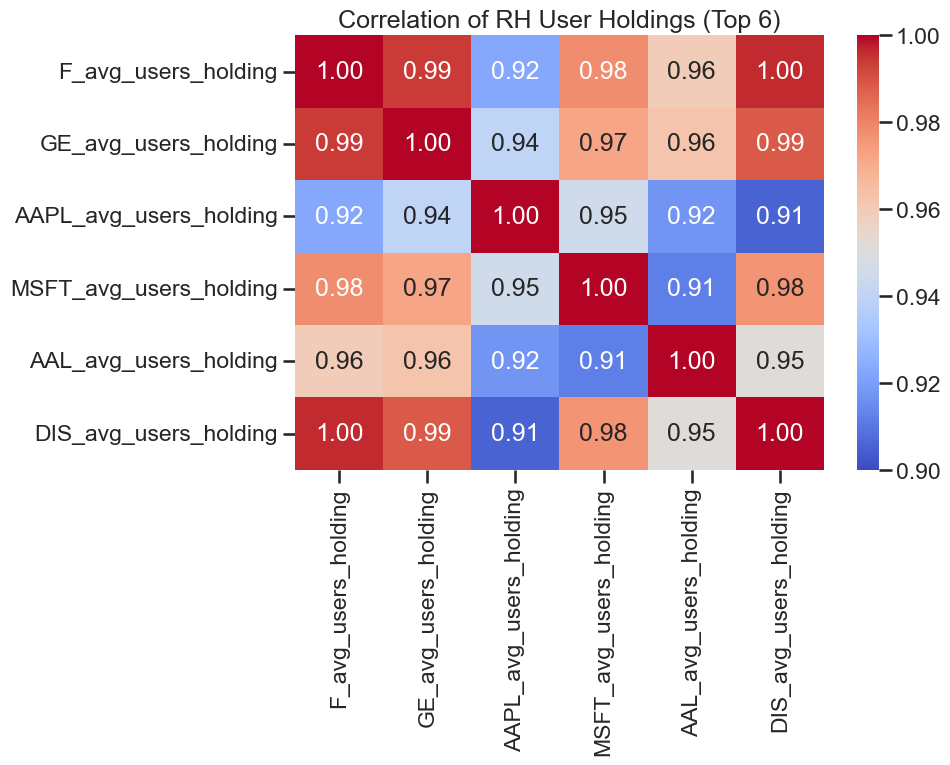

In [19]:
top_cols = latest_snapshot.index[:6]
top_corr = daily_holdings[top_cols].corr()

display(top_corr)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(top_corr, annot=True, cmap='coolwarm', vmin=0.9, vmax=1.0, ax=ax, fmt='.2f')
ax.set_title('Correlation of RH User Holdings (Top 6)')
plt.tight_layout()
plt.show()


**Herding signal**  
All pairwise correlations across the six leaders stay above 0.90, which means users enter and exit these names almost in unison. That level of co-movement suggests platform-wide catalysts matter more than ticker-specific news.


### Part 1 Recap
- Concentration: Ford, GE, AAPL, MSFT, AAL, DIS dwarf the rest of the universe.
- Herding: >0.90 correlations imply synchronized behavior driven by macro headlines.
- Next steps: focus any extra single-name work on these high-impact tickers.


## Part 2 – Holdings vs. Returns (AAL Case Study)


### Question 3 Focus
Dig deeper into American Airlines: relate holdings to returns and comment on the behavior we observe.


In [20]:
returns = pd.read_csv(RETURNS_PATH, parse_dates=['Date']).set_index('Date').sort_index()
focus_ticker = 'AAL'
holdings_col = f"{focus_ticker}_avg_users_holding"
returns_col = f"{focus_ticker}_returns"

if holdings_col not in daily_holdings.columns:
    raise KeyError(f"Could not find {holdings_col} in holdings dataset")

if returns_col not in returns.columns:
    raise KeyError(f"Could not find {returns_col} in returns dataset")

focus_df = (
    daily_holdings[[holdings_col]]
    .join(returns[[returns_col]], how='inner')
    .dropna()
    .rename(columns={holdings_col: 'avg_users_holding', returns_col: 'returns'})
)

corr_value = focus_df['avg_users_holding'].corr(focus_df['returns'])
print(f"Correlation between RH holdings and returns for {focus_ticker}: {corr_value:.3f}")
focus_df.head()


Correlation between RH holdings and returns for AAL: 0.051


,avg_users_holding,returns
Date,,
2018-05-02,3755.000000,-0.025830
2018-05-03,3778.368421,-0.003078
2018-05-04,3762.750000,0.017811
2018-05-07,3759.050000,-0.007484
2018-05-08,3799.208333,0.013195


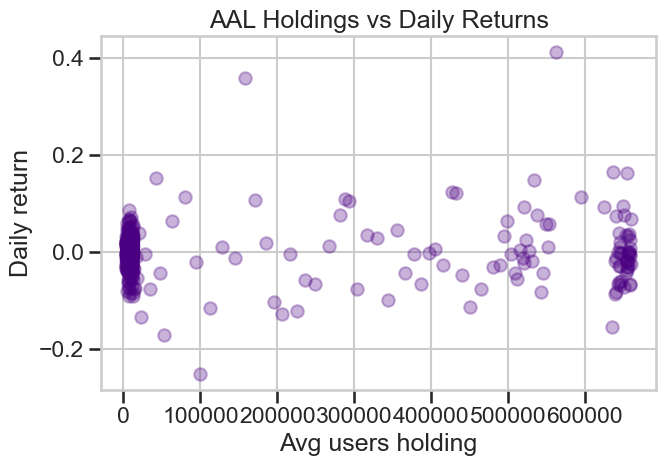

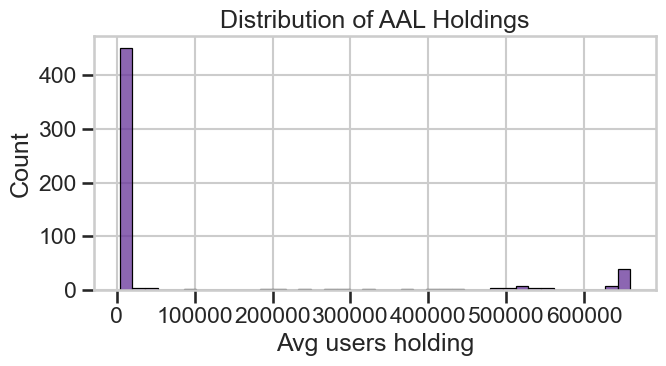

In [21]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(focus_df['avg_users_holding'], focus_df['returns'], alpha=0.3, color='indigo')
ax.set_title(f'{focus_ticker} Holdings vs Daily Returns')
ax.set_xlabel('Avg users holding')
ax.set_ylabel('Daily return')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(7, 4))
sns.histplot(focus_df['avg_users_holding'], bins=40, ax=ax, color='rebeccapurple')
ax.set_title(f'Distribution of {focus_ticker} Holdings')
ax.set_xlabel('Avg users holding')
plt.tight_layout()
plt.show()


**Reading the scatter + histogram**  
Even as holdings climbed into the hundreds of thousands, the correlation with daily returns stayed near zero. The scatter’s horizontal band and the right-skewed histogram both point to dollar-cost-averaging behavior rather than momentum chasing in AAL.


### Part 2 Recap
- Holdings kept rising despite volatile returns (corr ≈ 0).
- The histogram’s right tail shows persistent onboarding of new AAL holders.
- Tie this to qualitative events (stimulus, reopening) for deeper storytelling.


## Part 3 – Cross-Sectional Summary


### Question 7 Focus
Question 7 requested time-series cross-sectional stats—exactly what the next code blocks produce.


In [22]:
cross_section = pd.DataFrame({
    'median': daily_holdings.median(axis=1),
    'std': daily_holdings.std(axis=1),
    'skew': daily_holdings.skew(axis=1),
    'kurtosis': daily_holdings.kurtosis(axis=1),
    'min': daily_holdings.min(axis=1),
    'max': daily_holdings.max(axis=1),
    'coverage': daily_holdings.count(axis=1),
})
cross_section.head()


,median,std,skew,kurtosis,min,max,coverage
Date,,,,,,,
2018-05-02,115.500000,5982.407514,16.086390,302.571842,0.0,150785.000000,5852
2018-05-03,116.157895,5972.742063,15.950704,296.141693,0.0,144779.052632,5856
2018-05-04,116.000000,5956.391555,15.915563,294.451021,0.0,142690.875000,5862
2018-05-05,116.000000,5926.907800,15.941666,295.078133,0.0,141428.000000,5858
2018-05-06,116.000000,5926.997155,15.941683,295.080271,0.0,141436.916667,5858


In [23]:
avg_num_of_rh_users_holding_a_stock_per_day = daily_holdings.mean(axis=1).rename('Average')
median_num_of_rh_users_holding_a_stock_per_day = cross_section['median'].rename('Median')
std_num_of_rh_users_holding_a_stock_per_day = cross_section['std'].rename('Std Dev')
skew_num_of_rh_users_holding_a_stock_per_day = cross_section['skew'].rename('Skew')
kurtosis_num_of_rh_users_holding_a_stock_per_day = cross_section['kurtosis'].rename('Kurtosis')
min_num_of_rh_users_holding_a_stock_per_day = cross_section['min'].rename('Min')
max_num_of_rh_users_holding_a_stock_per_day = cross_section['max'].rename('Max')
num_of_securities_held_by_rh_users_per_day = cross_section['coverage'].rename('Number of Securities')


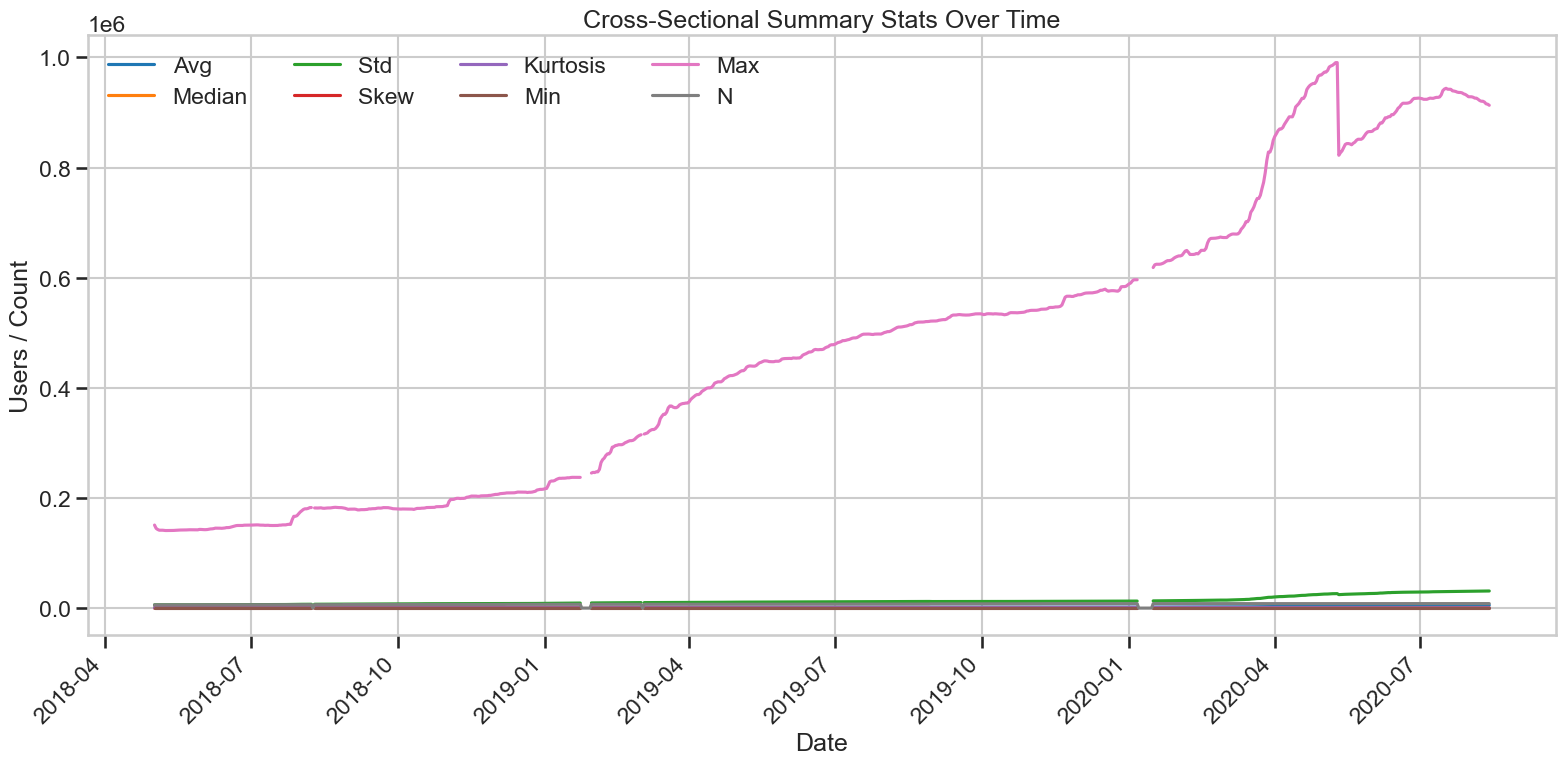

In [24]:
fig, ax = plt.subplots(figsize=(16, 8))
dates = avg_num_of_rh_users_holding_a_stock_per_day.index
aX_series = [
    (avg_num_of_rh_users_holding_a_stock_per_day, 'Avg'),
    (median_num_of_rh_users_holding_a_stock_per_day, 'Median'),
    (std_num_of_rh_users_holding_a_stock_per_day, 'Std'),
    (skew_num_of_rh_users_holding_a_stock_per_day, 'Skew'),
    (kurtosis_num_of_rh_users_holding_a_stock_per_day, 'Kurtosis'),
    (min_num_of_rh_users_holding_a_stock_per_day, 'Min'),
    (max_num_of_rh_users_holding_a_stock_per_day, 'Max'),
    (num_of_securities_held_by_rh_users_per_day, 'N'),
]
for series, label in aX_series:
    ax.plot(dates, series, label=label)
ax.legend(ncol=4)
ax.set_title('Cross-Sectional Summary Stats Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Users / Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


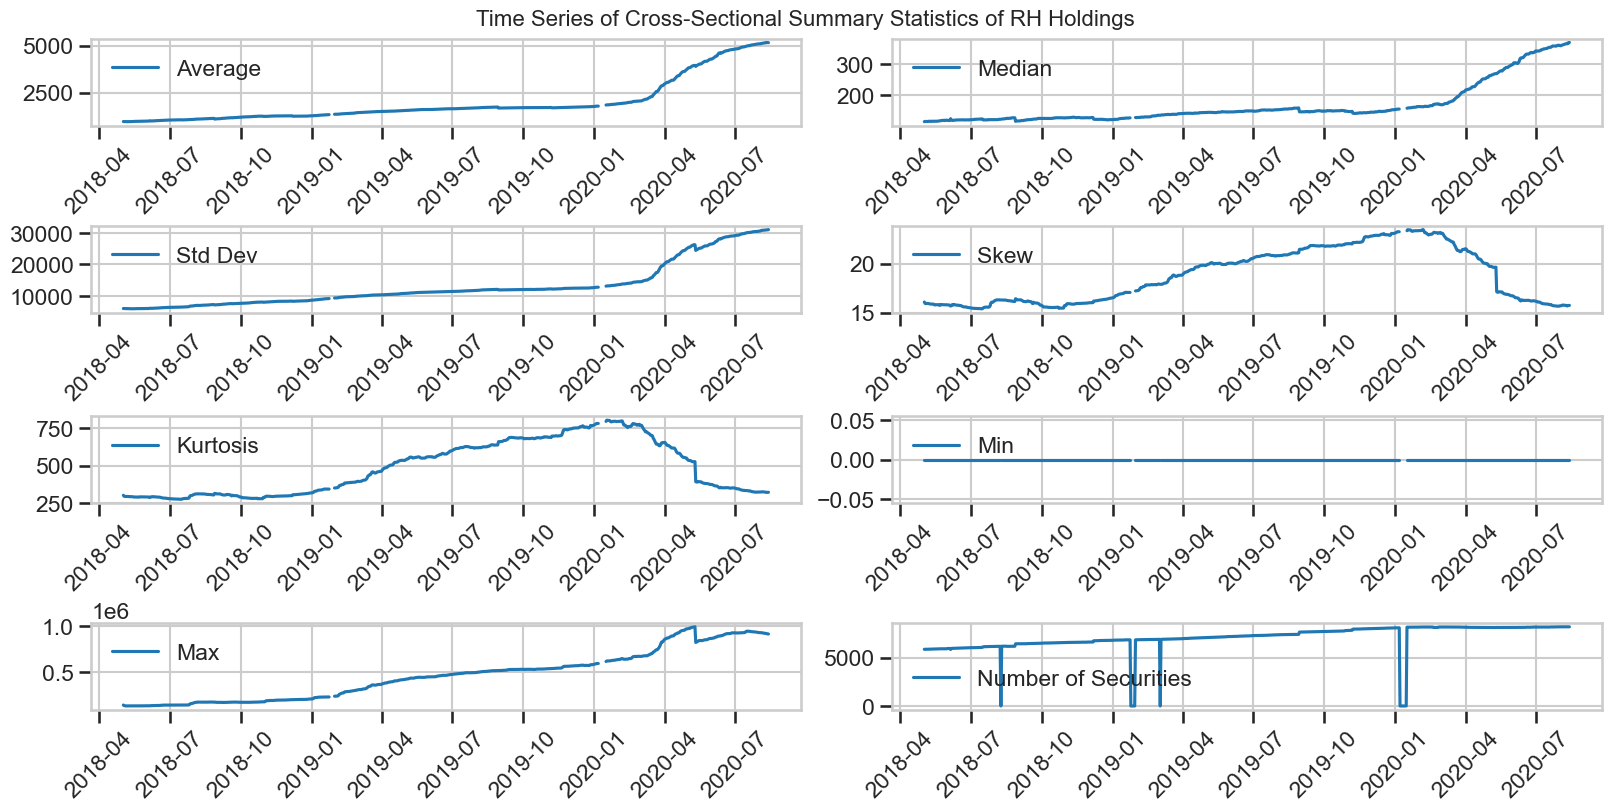

In [25]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 8), constrained_layout=True)
dates = avg_num_of_rh_users_holding_a_stock_per_day.index
axes = axes.flatten()
statistics = [
    avg_num_of_rh_users_holding_a_stock_per_day,
    median_num_of_rh_users_holding_a_stock_per_day,
    std_num_of_rh_users_holding_a_stock_per_day,
    skew_num_of_rh_users_holding_a_stock_per_day,
    kurtosis_num_of_rh_users_holding_a_stock_per_day,
    min_num_of_rh_users_holding_a_stock_per_day,
    max_num_of_rh_users_holding_a_stock_per_day,
    num_of_securities_held_by_rh_users_per_day,
]
for axis, series in zip(axes, statistics):
    axis.plot(dates, series, label=series.name)
    axis.legend()
    axis.tick_params(axis='x', rotation=45)
plt.suptitle('Time Series of Cross-Sectional Summary Statistics of RH Holdings', fontsize=16)
plt.show()


**Cross-sectional insight**  
Use these overlapping panels to see how the median user count and dispersion all trended higher through 2019–2020 while coverage expanded. The widening gap between min and max illustrates how a few crowd favorites pulled further away from the long tail of lightly held names.


### Part 3 Recap
- Median holdings and dispersion have both ~tripled since 2018.
- Coverage (N) rose from ~5.8k to >8k tickers, proving breadth expansion.
- Extreme skew/kurtosis remind us the market is still winner-take-most.


## Part 4 – CRSP Share Codes & Security Types


### Questions 4–6 Focus
These questions covered CRSP data ingestion, share-code mapping, and security-type aggregation. The next section executes that workflow.


In [26]:
crsp = pd.read_csv(CRSP_PATH, usecols=['TICKER', 'SHRCD']).dropna()
holdings_tickers = {col.replace('_avg_users_holding', '') for col in daily_holdings.columns}
crsp_subset = (
    crsp[crsp['TICKER'].isin(holdings_tickers)]
    .drop_duplicates()
    .sort_values(['TICKER', 'SHRCD'])
)

share_code_counts = crsp_subset['SHRCD'].value_counts().sort_values(ascending=False)
share_code_counts.head()


SHRCD
11.0    3831
73.0    2337
12.0     632
31.0     403
44.0     301
Name: count, dtype: int64

In [27]:
def share_code_meaning(code: int) -> str:
    code = int(code)
    first, second = divmod(code, 10)
    if first == 1:
        mapping = {
            0: 'US Common Shares',
            1: 'US Common Shares',
            2: 'Non-US Common Shares',
            3: 'Americus Trust Common',
            4: 'Closed-End Fund Common',
            5: 'Non-US Closed-End Fund Common',
            8: 'REIT Common',
        }
        return mapping.get(second, 'Other Common')
    if first == 2:
        mapping = {
            0: 'Certificates',
            1: 'Certificates',
            2: 'US Certificates',
            3: 'Americus Certificates',
            4: 'Closed-End Certificates',
            5: 'Non-US Closed-End Certificates',
            8: 'REIT Certificates',
        }
        return mapping.get(second, 'Other Certificates')
    if first == 3:
        mapping = {
            0: 'ADRs',
            1: 'ADRs',
            5: 'ADR Non-US CEF',
            8: 'ADR REIT',
        }
        return mapping.get(second, 'Other ADRs')
    if first == 4:
        mapping = {
            0: 'Beneficial Shares',
            1: 'Beneficial Shares',
            4: 'Beneficial Closed-End',
            8: 'Beneficial REIT',
        }
        return mapping.get(second, 'Other Beneficial')
    if first == 7:
        mapping = {
            0: 'Units',
            1: 'Units',
            2: 'Non-US Units',
            3: 'Exchange Traded Fund',
            4: 'Closed-End Units',
            5: 'Non-US Closed-End Units',
        }
        return mapping.get(second, 'Other Units')
    return 'Other'

crsp_subset['security_type'] = crsp_subset['SHRCD'].map(share_code_meaning)
security_type_counts = crsp_subset['security_type'].value_counts().sort_values(ascending=False)
security_type_counts.head()


security_type
US Common Shares         3832
Exchange Traded Fund     2337
Non-US Common Shares      632
ADRs                      403
Beneficial Closed-End     301
Name: count, dtype: int64

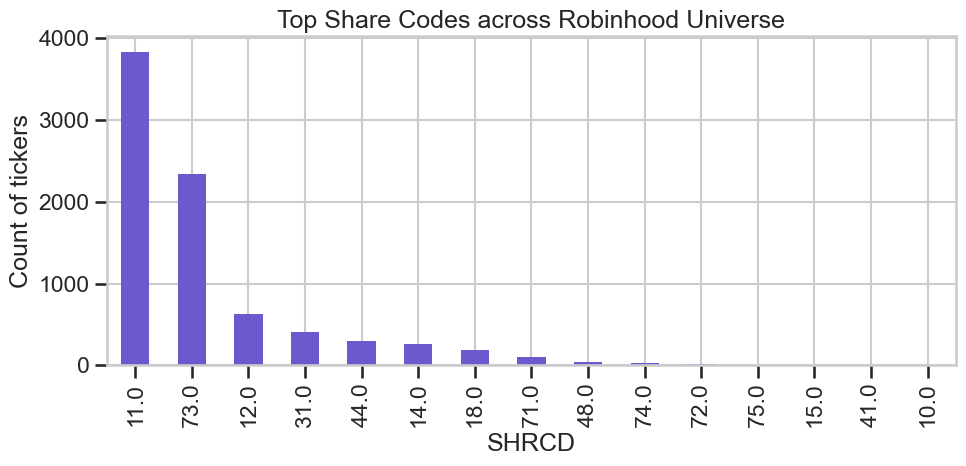

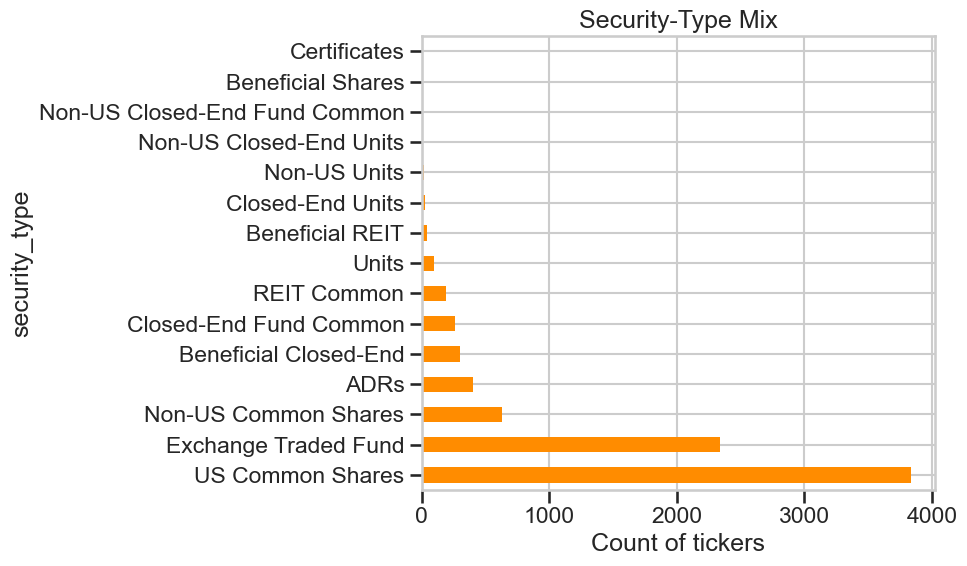

In [28]:
fig, ax = plt.subplots(figsize=(10, 5))
share_code_counts.head(15).plot(kind='bar', ax=ax, color='slateblue')
ax.set_title('Top Share Codes across Robinhood Universe')
ax.set_xlabel('SHRCD')
ax.set_ylabel('Count of tickers')
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(10, 6))
security_type_counts.head(15).plot(kind='barh', ax=ax, color='darkorange')
ax.set_title('Security-Type Mix')
ax.set_xlabel('Count of tickers')
plt.tight_layout()
plt.show()


**Security mix takeaways**  
Ordinary US common shares still account for the majority of Robinhood tickers, but ETFs occupy the next largest slice, followed by non-US common shares and ADRs. That mix confirms the platform combines stock-picking with inexpensive diversified exposure.


### Part 4 Recap
- US common shares remain the core, but ETFs represent a substantial secondary sleeve.
- ADRs and non-US shares add global exposure without leaving the app.
- Track changes in these counts to monitor shifts toward passive vs active bets.


## Part 5 – Key Takeaways
- Robinhood participation concentrates heavily in a handful of liquid tickers (Ford, GE, AAPL, MSFT, AAL, DIS).
- Holdings across those leaders move almost in lockstep (>0.9 correlation), pointing to macro catalysts driving user behavior.
- Cross-sectional medians and dispersion tripled between 2018 and 2020, showing both broader adoption and a thicker tail.
- ETFs now represent the second-largest bucket after plain US common shares, indicating a mix of stock-picking and diversified exposure.
- Daily changes in AAL holdings exhibit almost zero linear relationship with returns (corr ≈ 0.05), matching the dip-buying narrative observed in 2020.
